In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from rich.progress import track
from rich import progress
import IPython
import pandas as pd

from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    Force,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
    PlateElectrodes,
)
from centrex_trajectories.visualization import plot_beamline

C:\Users\ogras\AppData\Local\Temp\ipykernel_22320\2876790632.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{( task.speed or 0 ):.1f}/s"
        else:
            return f"{( 1 / task.speed or 0):.1f} s/i"

In [4]:
n_trajectories = 10_000_000
options = PropagationOptions(verbose=False, n_cores=8)
gravity = Gravity(0, -9.81, 0)
particle = TlF()

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters
wx_det = 13e-3
wy_det = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 2

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_width = 8e-3
rc_aperture_height = 6e-3

## Beamline Sections

| What | Length |
| --- | --- |  
| bs flange | 3/4" |
| center of the RC chamber to the beamsource front | 16-3/8" |
| center of the SPA chamber to the beamsource front | 28-3/8" |
| front of the EQL chamber to the beamsource front | 36" |
| lens chamber length | 24-5/8" |
| lens electrode length | 0.6 m |
| lens flange with o-ring | 7/8" |
| lens reducer | 3-1/8" |
| center of DET to start chamber | 5-1/4" |
| long nipple length | 39" |
| rc chamber length without flanges | 10.5" |
| rc chamber front without flanges to front bs flange | 10-3/8" |
| rc aperture from center rc | 3.56" | 
| rc aperture width | 8 mm |
| rc aperture height | 6 mm | 

In [5]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=1e-2,
        ),
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = Section(
    name="Electrostatic Lens",
    objects=[],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2
    + 1e-3,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

In [6]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

sections = [fourK, fourtyK, bbexit, rc, spa, eql]
section_data, trajectories = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)

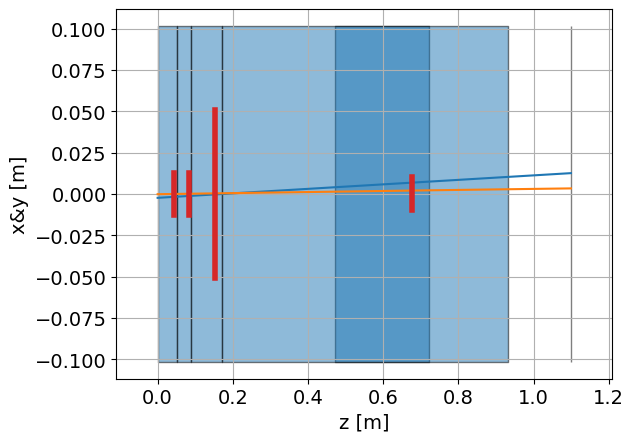

In [7]:
traj = trajectories[list(trajectories.keys())[0]]

fig, ax = plt.subplots()
ax.plot(traj.z, traj.x)
ax.plot(traj.z, traj.y)

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x&y [m]")

ax.grid(True)

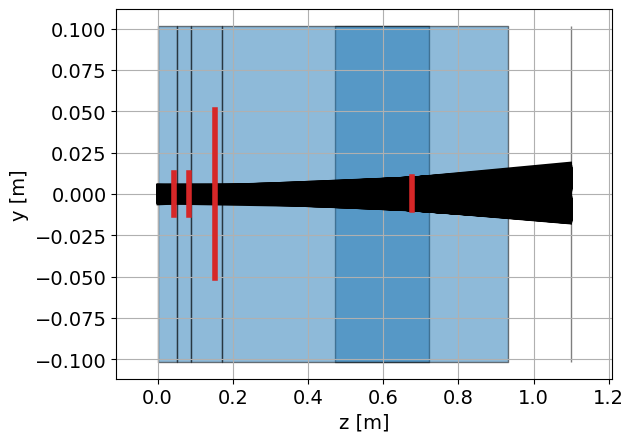

In [8]:
fig, ax = plt.subplots()
for traj in trajectories.values():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

## Scan with EQL and DET

In [10]:
def scan_function(
    origin: Coordinates,
    velocities: Velocities,
    rc_radius: float,
    eql_voltage: float,
    distance_det: float,
    eql_length: float = 0.6,
    eql_radius: float = 0.022225,
    wx_det: float = 2e-2,
    wy_det: float = 1 * in_to_m,
    wx_int: float = 2e-2,
    wy_int: float = 3 * in_to_m,
):
    rc = Section(
        name="Rotational cooling",
        objects=[
            CircularAperture(
                x=0,
                y=0,
                z=bbexit.stop
                + rc_chamber_center_from_bs_front
                + rc_aperture_from_center,
                r=rc_radius,
            ),
        ],
        start=bbexit.stop
        + bs_flange
        + rc_chamber_center_from_bs_front
        - rc_chamber_length_no_flanges / 2,
        stop=bbexit.stop
        + rc_chamber_center_from_bs_front
        + rc_chamber_length_no_flanges / 2,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    eql = ElectrostaticQuadrupoleLens(
        name="Electrostatic Lens",
        objects=[
            Bore(
                x=0,
                y=0,
                z=bbexit.stop
                + distance_lens_bbexit
                + (lens_chamber_length - lens_electrode_length) / 2,
                length=eql_length,
                radius=R,
            )
        ],
        start=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2,
        stop=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2
        + eql_length,
        V=eql_voltage,
        R=eql_radius,
        save_collisions=True,
    )

    pre_interaction_aperture = Section(
        name="Pre-Interaction Aperture",
        objects=[
            RectangularAperture(x=0, y=0, z=eql.stop + 1.4925, wx=wx_int, wy=wy_int)
        ],
        start=eql.stop + 1.49,
        stop=eql.stop + 1.495,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    interaction = Section(
        name="Interaction",
        objects=[
            PlateElectrodes(
                x=0, y=0, z=eql.stop + 1.5, length=2.5, width=20e-2, separation=2e-2
            ),
        ],
        start=eql.stop + 1.5,
        stop=eql.stop + 4,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + distance_det,
                wx_det,
                wy_det,
            )
        ],
        start=eql.stop + distance_det - 1e-3,
        stop=eql.stop + distance_det + 1e-3,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [
        fourK,
        fourtyK,
        bbexit,
        rc,
        spa,
        eql,
        pre_interaction_aperture,
        interaction,
        det,
    ]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [11]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

radii = np.arange(1e-3, 1.75 / 2 * in_to_m, 2e-3)
voltages = np.linspace(0, 30e3, 13)

data = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("radius", total=len(radii))
    t2 = pb.add_task("voltage", total=len(voltages))
    for idr, radius in enumerate(radii):
        dat = []
        for idv, voltage in enumerate(voltages):
            dat.append(
                scan_function(origin, velocities, radius, voltage, distance_det=5.0)
            )
            pb.update(task_id=t2, completed=idv + 1)
        if idr < len(radii) - 1:
            pb.reset(t2)
        pb.update(task_id=t1, completed=idr + 1)
        data.append((radius, dat))
    pb.refresh()

Output()

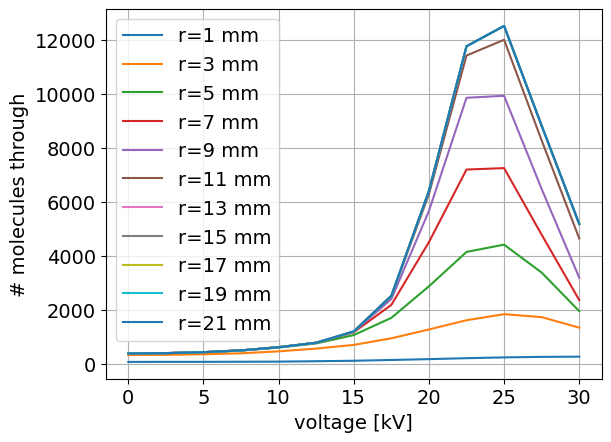

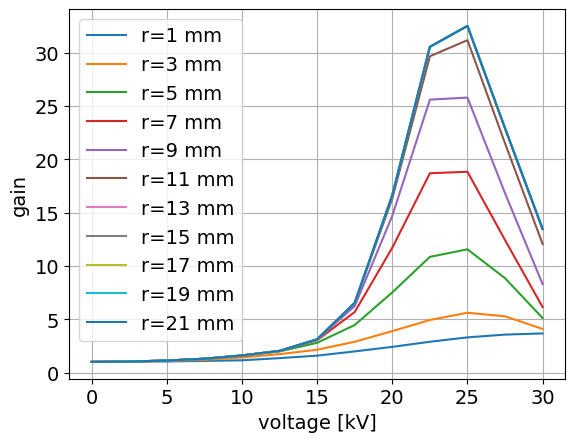

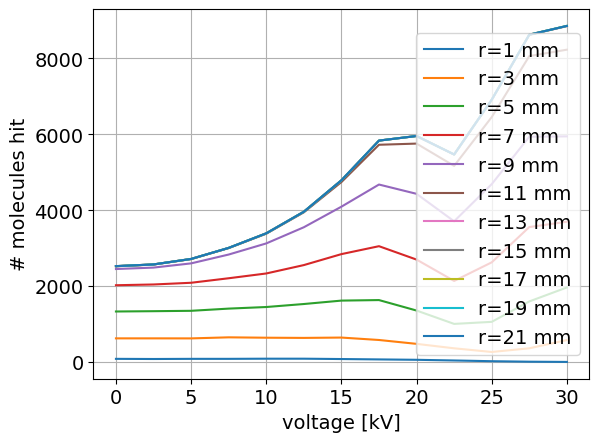

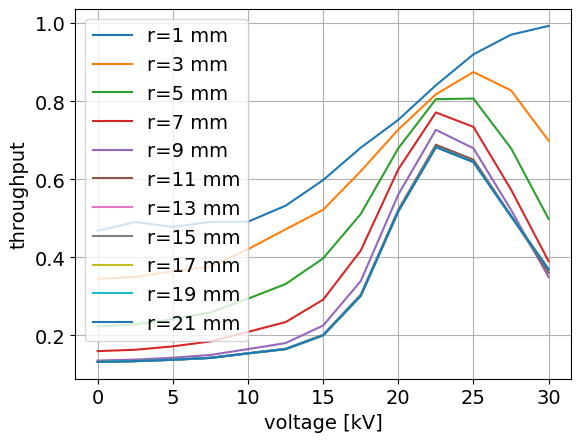

In [12]:
survived = np.array(
    [[sec_dat[-1].survived for sec_dat, _, _ in dat] for _, dat in data]
)
hit = np.array(
    [[sec_dat[-1].nr_collisions for sec_dat, _, _ in dat] for _, dat in data]
)
throughput = np.array(
    [[sec_dat[-1].throughput for sec_dat, _, _ in dat] for _, dat in data]
)

labels = [f"r={r*1e3:.0f} mm" for r in radii][: len(survived)]

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules through")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T / survived.T[0, :], label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, hit.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules hit")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, throughput.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("throughput")
ax.legend()
ax.grid(True)

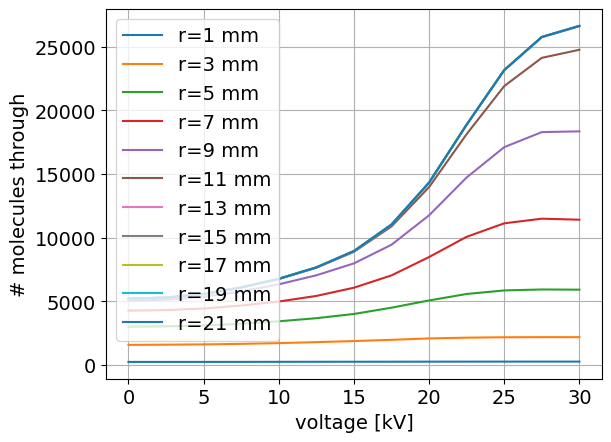

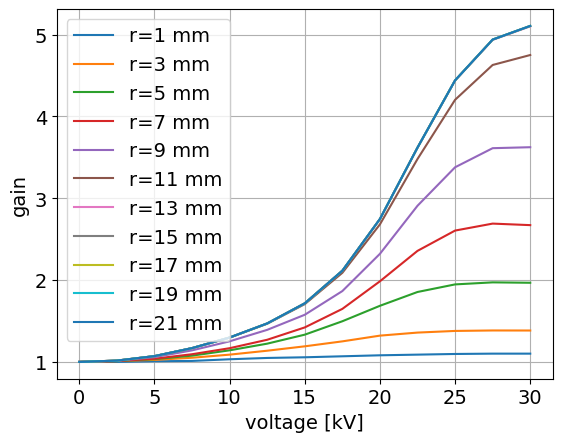

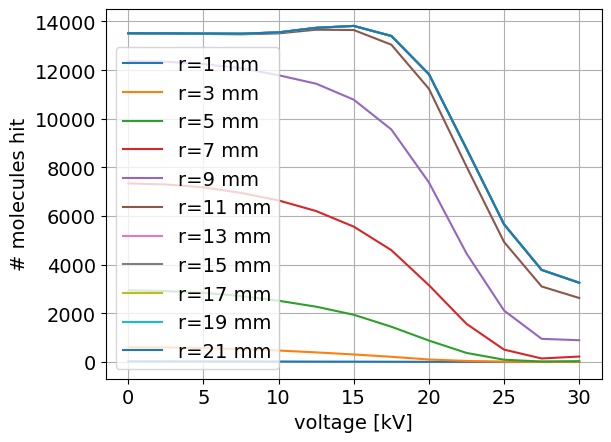

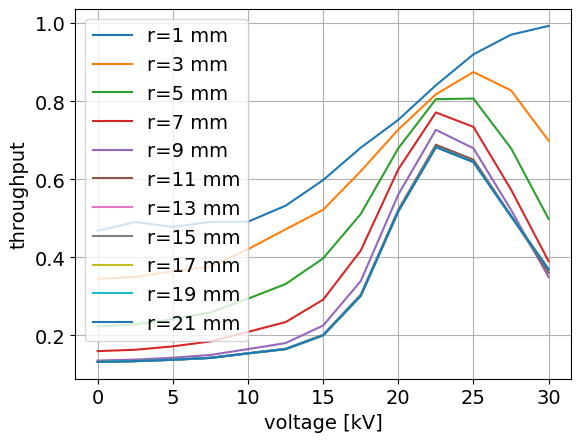

In [15]:
survived = np.array(
    [[sec_dat[-3].survived for sec_dat, _, _ in dat] for _, dat in data]
)
hit = np.array(
    [[sec_dat[-3].nr_collisions for sec_dat, _, _ in dat] for _, dat in data]
)
througput = np.array(
    [[sec_dat[-3].throughput for sec_dat, _, _ in dat] for _, dat in data]
)

labels = [f"r={r*1e3:.0f} mm" for r in radii][: len(survived)]

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules through")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T / survived.T[0, :], label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, hit.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules hit")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, throughput.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("throughput")
ax.legend()
ax.grid(True)

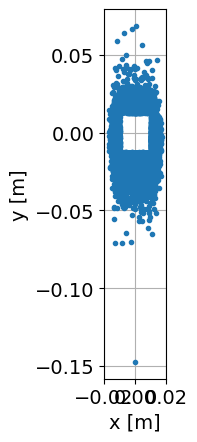

In [16]:
collisions_det = [
    [sec_dat[-1].saved_collisions for sec_dat, _, _ in dat] for _, dat in data
]

col = collisions_det[-6][-3][0][0]

fig, ax = plt.subplots()
ax.plot(col.x, col.y, ".")
ax.set_aspect(1)
ax.set_xlim(-2e-2, 2e-2)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)

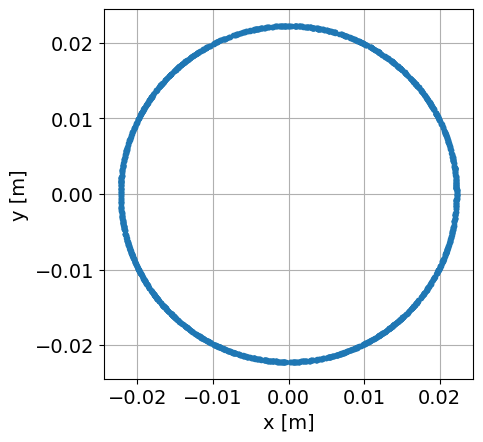

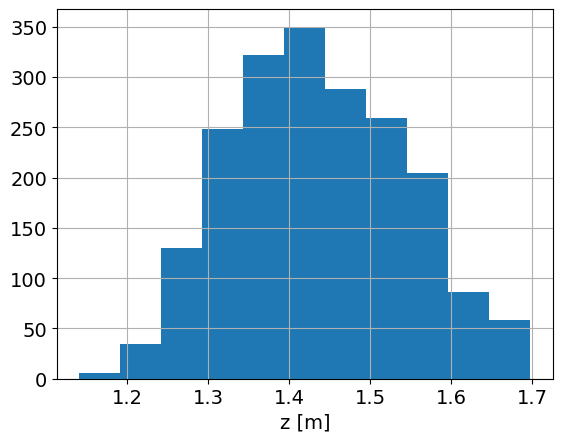

In [17]:
collisions_lens_entry = [
    [sec_dat[-4].saved_collisions for sec_dat, _, _ in dat] for _, dat in data
]


col = collisions_lens_entry[-6][-3][1][0]
vel = collisions_lens_entry[-6][-3][1][1]

fig, ax = plt.subplots()
ax.plot(col.x, col.y, ".")
# ax.add_patch(plt.Circle((0, 0), radius=R, fill=False, color="k", lw=3, zorder=10))
ax.set_aspect(1)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)

fig, ax = plt.subplots()
ax.hist(col.z, bins=11)
ax.set_xlabel("z [m]")
ax.grid(True)

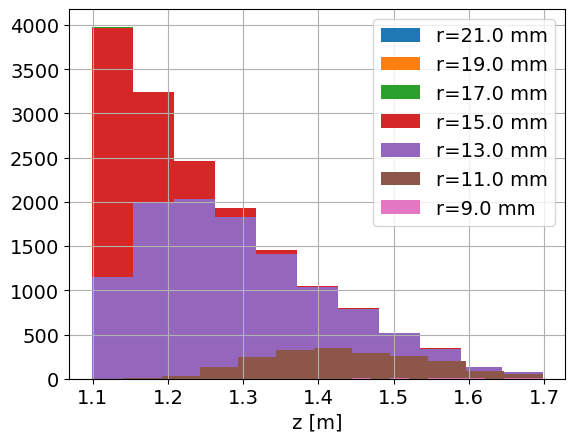

In [18]:
fig, ax = plt.subplots()
for idx in reversed(range(len(radii))):
    try:
        col = collisions_lens_entry[idx][-3][1][0]
    except:
        continue

    ax.hist(col.z, bins=11, label=f"r={radii[idx]*1e3:.1f} mm")

ax.legend()
ax.set_xlabel("z [m]")
ax.grid(True)

In [19]:
collisions_interaction = [
    [sec_dat[-2].saved_collisions for sec_dat, _, _ in dat] for _, dat in data
]

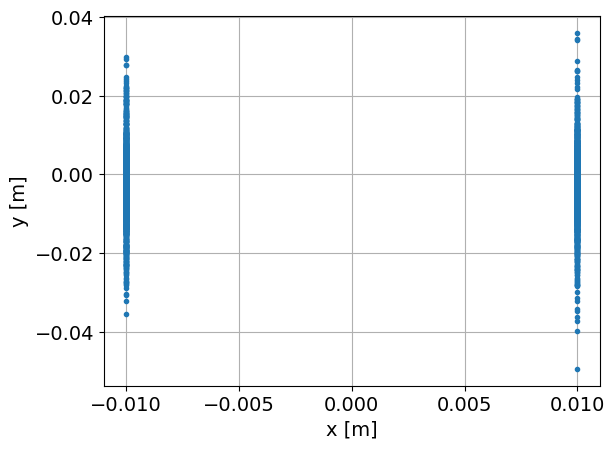

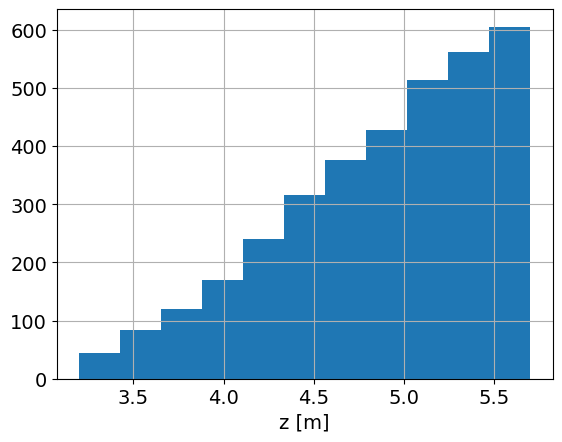

In [20]:
col = collisions_interaction[-6][-3][0][0]
vel = collisions_interaction[-6][-3][0][1]

m = ~(((col.x > 0) & (vel.vx < 0)) | ((col.x < 0) & (vel.vx > 0)))

fig, ax = plt.subplots()
ax.plot(col.x[m], col.y[m], ".")
# ax.set_aspect(1)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)

fig, ax = plt.subplots()
ax.hist(col.z[m], bins=11)
ax.set_xlabel("z [m]")
ax.grid(True)

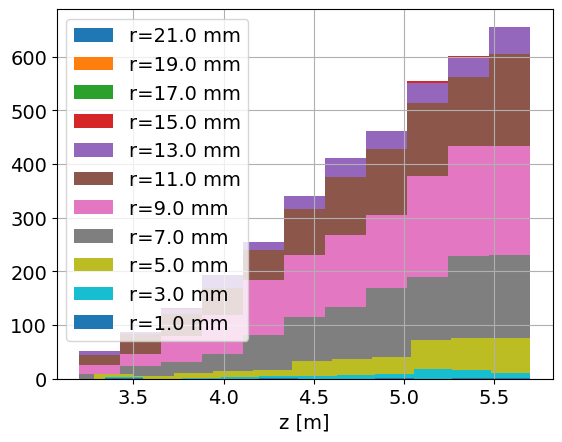

In [21]:
fig, ax = plt.subplots()
for idx in reversed(range(len(radii))):
    col = collisions_interaction[idx][-3][0][0]
    vel = collisions_interaction[idx][-3][0][1]

    m = ~(((col.x > 0) & (vel.vx < 0)) | ((col.x < 0) & (vel.vx > 0)))

    ax.hist(col.z[m], bins=11, label=f"r={radii[idx]*1e3:.1f} mm")

ax.legend()
ax.set_xlabel("z [m]")
ax.grid(True)

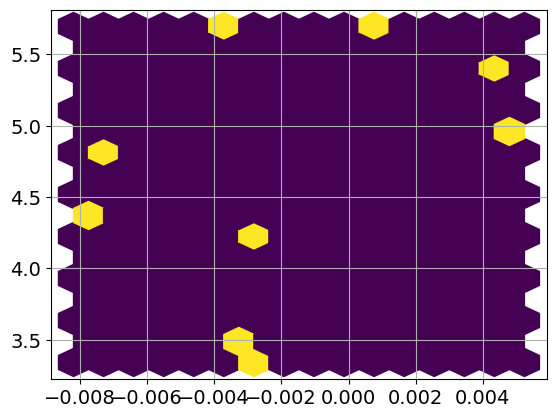

In [22]:
fig, ax = plt.subplots()
ax.hexbin(col.y[m], col.z[m], gridsize=15)

ax.grid(True)

## Bayesian Optimization

In [263]:
def objective_function(parametrization) -> dict:
    rc_radius = parametrization.get("rc_radius")
    wx_int = parametrization.get("wx_int")
    wx_det = 2e-2
    eql_voltage = parametrization.get("eql_voltage")
    distance_det = 5.0

    section_data, trajectories, sections = scan_function(
        origin=origin,
        velocities=velocities,
        rc_radius=rc_radius,
        eql_voltage=eql_voltage,
        distance_det=distance_det,
        wx_int=wx_int,
        wx_det=wx_det,
    )
    assert section_data[-2].name == "Interaction"
    return {
        "detected": (section_data[-1].survived, np.sqrt(section_data[-1].survived)),
        "hit_interaction": (
            section_data[-2].nr_collisions,
            np.sqrt(section_data[-2].nr_collisions),
        ),
    }

In [264]:
import torch
from ax.plot.pareto_frontier import plot_pareto_frontier
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

# Plotting imports and initialization
from ax.utils.notebook.plotting import init_notebook_plotting, render

init_notebook_plotting()

[INFO 02-14 11:58:50] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 02-14 11:58:50] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [280]:
ax_client = AxClient()

ax_client.create_experiment(
    name="aperture_placement",
    parameters=[
        {
            "name": "rc_radius",
            "type": "range",
            "bounds": [5e-3, 20e-3],
        },
        {"name": "wx_int", "type": "range", "bounds": [1e-3, 20e-3]},
        {"name": "eql_voltage", "type": "range", "bounds": [0.0, 30e3]},
    ],
    objectives={
        # `threshold` arguments are optional
        "detected": ObjectiveProperties(minimize=False, threshold=None),
        "hit_interaction": ObjectiveProperties(minimize=True, threshold=None),
    },
    overwrite_existing_experiment=True,
    is_test=False,
)

[INFO 02-14 14:13:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter rc_radius. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter wx_int. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter eql_voltage. If t

In [ ]:
optimization_steps = 200

with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("multi-objective optimize", total=optimization_steps)
    for i in range(optimization_steps):
        parameters, trial_index = ax_client.get_next_trial()
        # Local evaluation here can be replaced with deployment to external system.
        ax_client.complete_trial(
            trial_index=trial_index, raw_data=objective_function(parameters)
        )
        pb.update(task_id=t1, completed=i + 1)
        pb.refresh()

In [282]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["detected", "hit_interaction"],
    num_points=30,
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

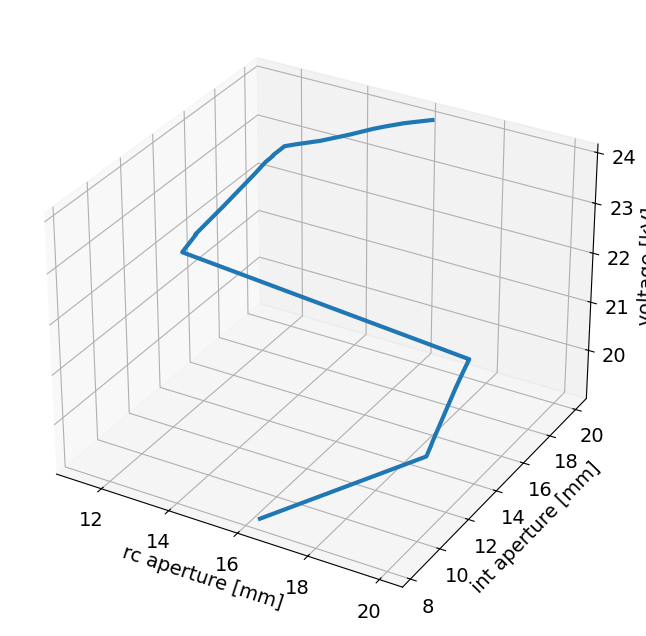

In [283]:
hit, det = np.asarray(list(frontier.means.values()))
sort_indices = np.argsort(det)

rc, wx_int, v = np.array([list(val.values()) for val in frontier.param_dicts])[
    sort_indices
].T
hit = hit[sort_indices]
det = det[sort_indices]

ax = plt.figure(figsize=(13, 8)).add_subplot(projection="3d")

ax.plot(rc * 1e3, wx_int * 1e3, v / 1e3, "-", lw=3)


ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")

fig.tight_layout()

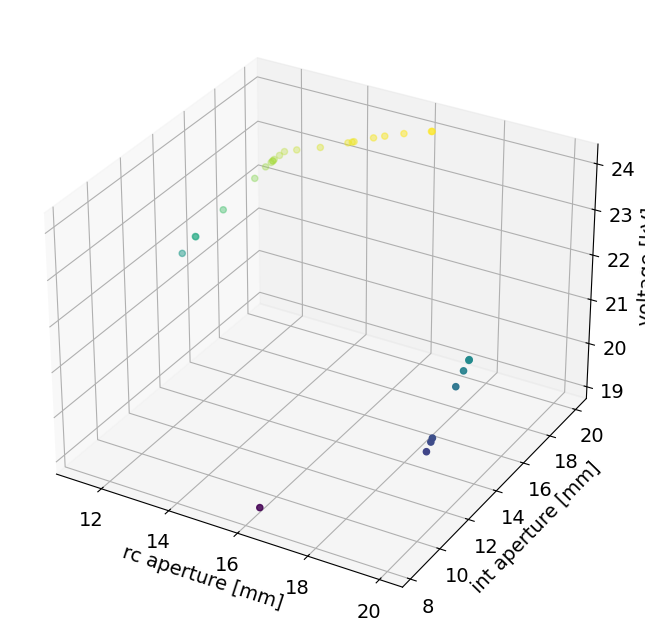

In [284]:
hit, det = np.asarray(list(frontier.means.values()))
sort_indices = np.argsort(det)

rc, wx_int, v = np.array([list(val.values()) for val in frontier.param_dicts])[
    sort_indices
].T
hit = hit[sort_indices]
det = det[sort_indices]

ax = plt.figure(figsize=(13, 8)).add_subplot(projection="3d")

ax.scatter(rc * 1e3, wx_int * 1e3, v / 1e3, c=det)


ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")

fig.tight_layout()

In [285]:
import matplotlib
import itertools


def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x


xi, yi, zi = (
    np.linspace(rc.min(), rc.max(), 31) * 1e3,
    np.linspace(wx_int.min(), wx_int.max(), 31) * 1e3,
    np.linspace(v.min(), v.max(), 31) / 1e3,
)
X, Y, Z = np.meshgrid(xi, yi, zi, indexing="ij")


x, y, z = midpoints(X), midpoints(Y), midpoints(Z)


dat = np.zeros(x.shape)
face_det = np.zeros(list(x.shape))
face_hit = np.zeros(list(x.shape))
for rci, wx_inti, vi, deti, hiti in zip(rc, wx_int, v, det, hit):
    idx = np.argmin((x[:, 0, 0] - rci * 1e3) ** 2)
    idy = np.argmin((y[0, :, 0] - wx_inti * 1e3) ** 2)
    idz = np.argmin((z[0, 0, :] - vi / 1e3) ** 2)
    dat[idx, idy, idz] = 1
    face_det[idx, idy, idz] = deti
    face_hit[idx, idy, idz] = hiti


cmap = matplotlib.colormaps.get("viridis")
mapping_det = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(face_det.min(), face_det.max()), cmap=cmap
)

mapping_hit = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(face_hit.min(), face_hit.max()), cmap=cmap
)


_face_det = np.zeros(list(face_det.shape) + [3])
_face_hit = np.zeros(list(face_det.shape) + [3])
for idx, idy, idz in itertools.product(*[range(s) for s in face_det.shape]):
    _face_det[idx, idy, idz, :] = mapping_det.to_rgba(face_det[idx, idy, idz])[:3]
    _face_hit[idx, idy, idz, :] = mapping_hit.to_rgba(face_hit[idx, idy, idz])[:3]

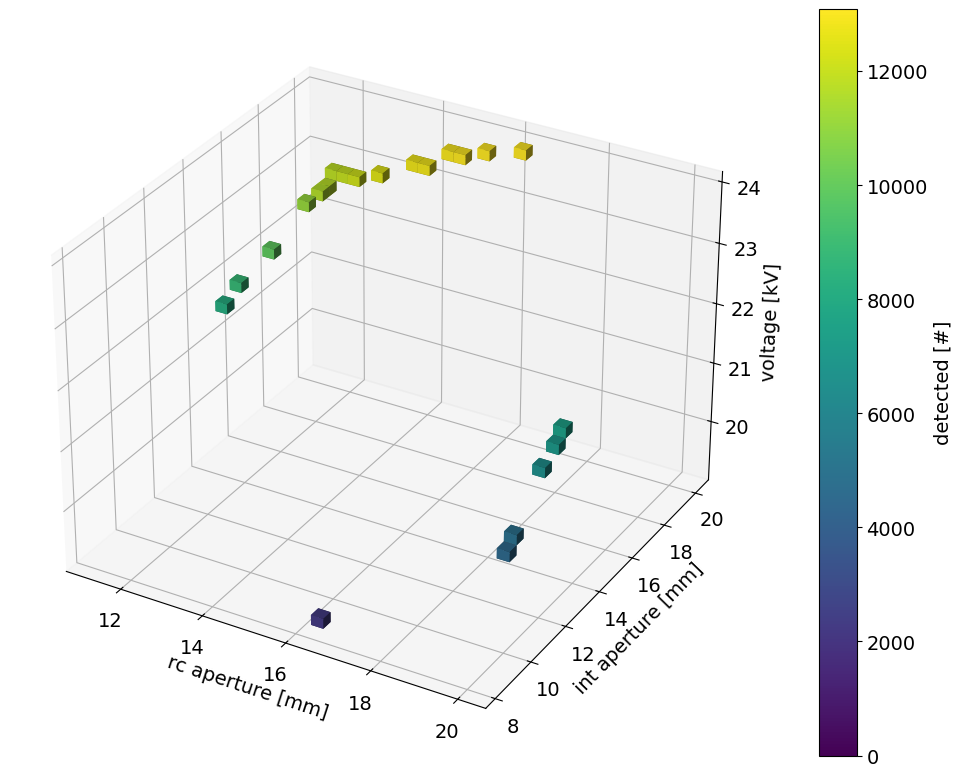

In [286]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(projection="3d")


ax.voxels(X, Y, Z, dat, facecolors=_face_det)

cbar = fig.colorbar(mapping_det, ax=ax)

ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")
cbar.ax.set_ylabel("detected [#]")

fig.tight_layout()

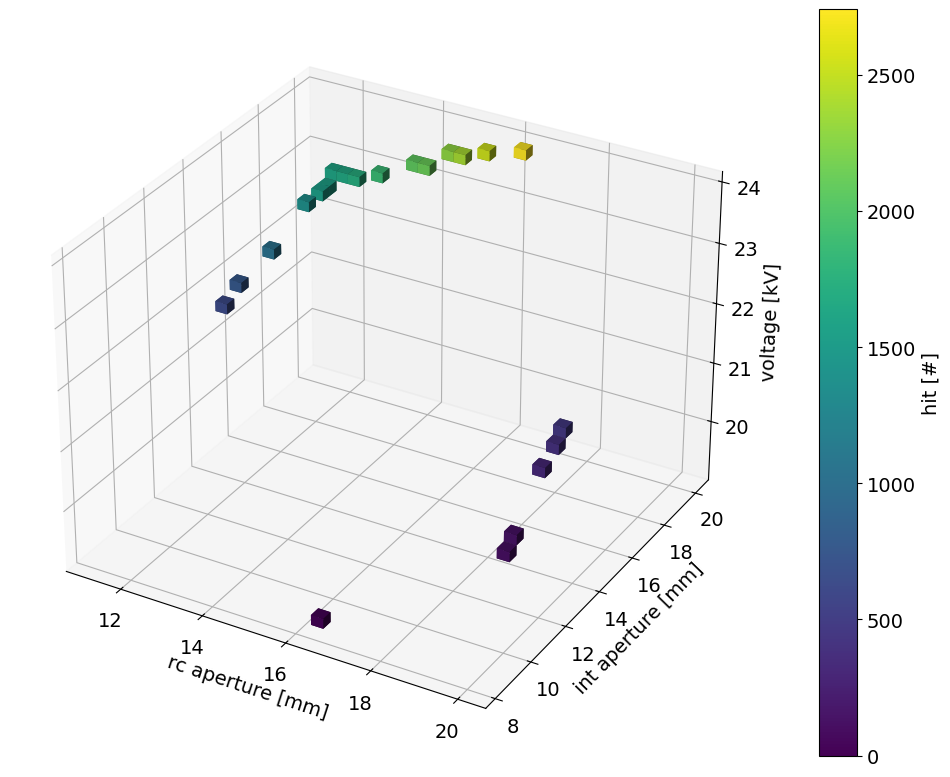

In [287]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(projection="3d")


ax.voxels(X, Y, Z, dat, facecolors=_face_hit)

cbar = fig.colorbar(mapping_hit, ax=ax)

ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")
cbar.ax.set_ylabel("hit [#]")

fig.tight_layout()

## Plot one trajectory

In [259]:
sec_dat, trajectories, sections = scan_function(
    origin,
    velocities,
    rc_radius=18e-3,
    eql_voltage=23e3,
    distance_det=5.0,
    wx_int=19.5e-3,
)

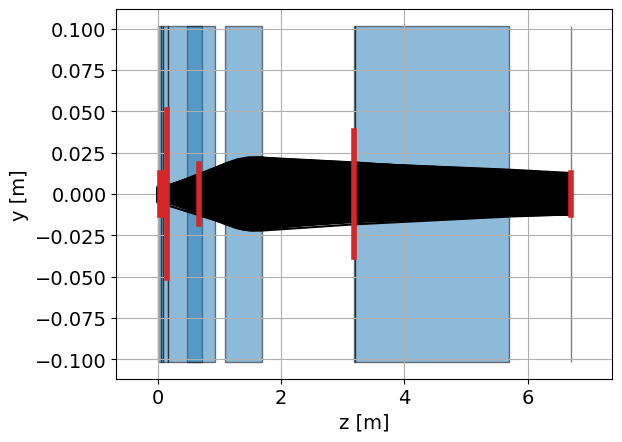

In [260]:
fig, ax = plt.subplots()

idt = 0
for traj in trajectories.values():
    ax.plot(traj.z, traj.y, color="k")
    idt += 1
    if idt == 2_000:
        break

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

## Scan voltages and apertures

In [19]:
n_trajectories = 40_000_000
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

radii = np.arange(3e-3, 1.75 / 2 * in_to_m, 2e-3)
interaction_apertures = np.arange(4e-3, 2.1e-2, 2e-3)
voltages = np.arange(16_000, 30_001, 2_000)

data_scan = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("radius", total=len(radii))
    t2 = pb.add_task("interaction", total=len(interaction_apertures))
    t3 = pb.add_task("voltage", total=len(voltages))
    for idr, radius in enumerate(radii):
        for idi, interaction in enumerate(interaction_apertures):
            for idv, voltage in enumerate(voltages):
                sec_dat, traj, secs = scan_function(
                    origin,
                    velocities,
                    radius,
                    voltage,
                    distance_det=5.0,
                    wx_int=interaction,
                    wy_int=2 * in_to_m,
                    wx_det=0.04,
                    wy_det=2 * in_to_m,
                )
                data_scan.append(
                    (
                        radius,
                        interaction,
                        voltage,
                        sec_dat[-4].saved_collisions[0][0],
                        sec_dat[-2].saved_collisions[0][0],
                        sec_dat[-1].survived,
                    )
                )
                pb.update(task_id=t3, completed=idv + 1)
            if idi < len(interaction_apertures) - 1:
                pb.reset(t3)
            pb.update(task_id=t2, completed=idi + 1)
        if idr < len(radii) - 1:
            pb.reset(t2)
            pb.reset(t3)
        pb.update(task_id=t1, completed=idr + 1)
    pb.refresh()

Output()

In [20]:
import pickle

with open("scan.pkl", "wb") as f:
    pickle.dump(data_scan, f)


In [21]:
import pickle

with open("scan.pkl", "rb") as f:
    data_scan = pickle.load(f)


In [22]:
interaction_start = (
    bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2
    + 0.6
    + 1.5
)

In [23]:
molecules_J0_F0_pulse = 24e11

voltage = 24000 V; 10398 hit / 73698 survived


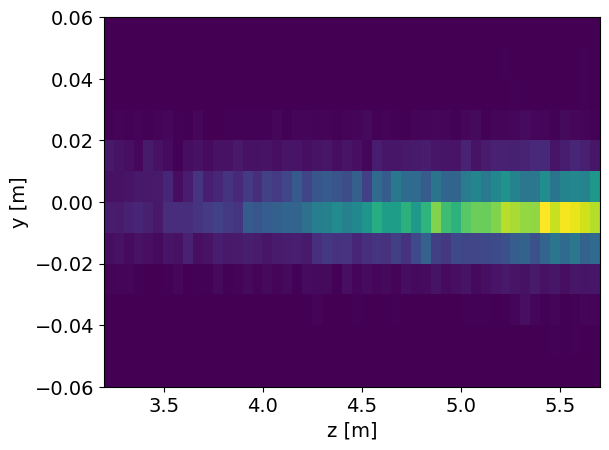

In [24]:
r, i, v, lens, plate, s = data_scan[-4]

bin_size_y = 1e-2
bin_size_z = 5e-2
fig, ax = plt.subplots()
_ = ax.hist2d(
    plate.z,
    plate.y,
    bins=(
        np.arange(interaction_start, interaction_start + 2.5 + 1e-3, bin_size_z),
        np.arange(-6e-2, 6e-2 + 1e-3, bin_size_y),
    ),
)
ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

print(f"voltage = {v} V; {plate.x.size} hit / {s} survived")

In [45]:
bin_size_y = 1e-2
bin_size_z = 5e-2

bins = (
    np.arange(interaction_start, interaction_start + 2.5 + 1e-3, bin_size_z),
    np.arange(-6e-2, 6e-2 + 1e-3, bin_size_y),
)

dat_opt = []

for r, i, v, lens, plate, s in data_scan:
    hist, xedges, yedges = np.histogram2d(plate.z, plate.y, bins=bins)

    # divide hits by two because there are 2 plates
    hits_cm2 = (
        hist.max()
        * molecules_J0_F0_pulse
        / n_trajectories
        / (bin_size_y * bin_size_z * 1e4)
    ) / 2
    dat_opt.append((r, i, v, hits_cm2, s * molecules_J0_F0_pulse / n_trajectories))
dat_opt = np.asarray(dat_opt)


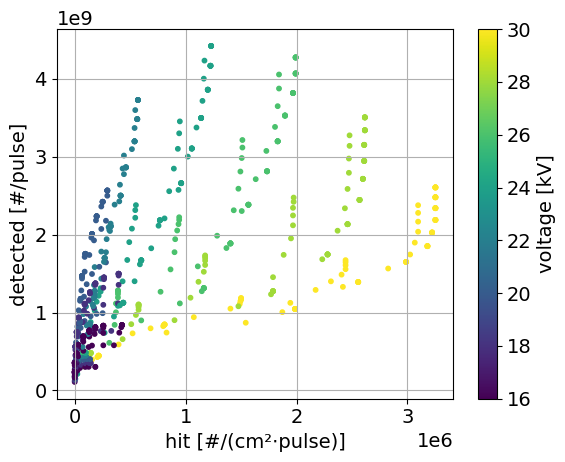

In [62]:
fig, ax = plt.subplots()

cax = ax.scatter(dat_opt[:, 3], dat_opt[:, 4], s=10, c=dat_opt[:, 2] / 1e3)

cbar = fig.colorbar(cax)

ax.set_xlabel("hit [#/(cm²⋅pulse)]")
ax.set_ylabel("detected [#/pulse]")
cbar.ax.set_ylabel("voltage [kV]")
ax.grid(True)


C:\Users\ogras\AppData\Local\Temp\ipykernel_29324\1901165226.py:4: RuntimeWarning: divide by zero encountered in divide
  1e15 / (dat_opt[:, 3] * 50 * 3600 * 24), dat_opt[:, 4], s=10, c=dat_opt[:, 2] / 1e3


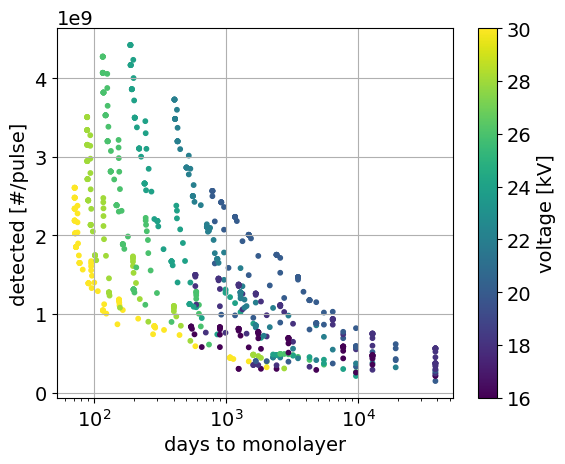

In [61]:
fig, ax = plt.subplots()

cax = ax.scatter(
    1e15 / (dat_opt[:, 3] * 50 * 3600 * 24), dat_opt[:, 4], s=10, c=dat_opt[:, 2] / 1e3
)

cbar = fig.colorbar(cax)

ax.set_xscale("log")

ax.set_xlabel("days to monolayer")
ax.set_ylabel("detected [#/pulse]")
cbar.ax.set_ylabel("voltage [kV]")
ax.grid(True)


In [98]:
import plotly.express as px

fig = px.scatter(
    x=1e15 / (dat_opt[:, 3] * 50 * 3600 * 24),
    y=dat_opt[:, 4],
    color=dat_opt[:, 2] / 1e3,
    log_x=True,
    height=500,
    width=650,
    labels={"x": "days to monolayer", "y": "detected [#/pulse]", "color": "kV"},
    hover_data={"radius": dat_opt[:, 0], "aperture": dat_opt[:, 1]},
    color_continuous_scale="viridis",
)
fig.update_layout(font=dict(size=18), yaxis={"tickformat": ".1e"})
fig.show()
fig.write_html("interactive.html")


C:\Users\ogras\AppData\Local\Temp\ipykernel_29324\2907756942.py:4: RuntimeWarning:

divide by zero encountered in divide



In [39]:
bin_size_y = 1e-2
bin_size_z = 5e-2

bins = (
    np.arange(interaction_start, interaction_start + 2.5 + 1e-3, bin_size_z),
    np.arange(-6e-2, 6e-2 + 1e-3, bin_size_y),
)

dat_opt = {}
for r, i, v, lens, plate, s in data_scan:
    hist, xedges, yedges = np.histogram2d(plate.z, plate.y, bins=bins)

    # divide hits by two because there are 2 plates
    hits_cm2 = (
        hist.max()
        * molecules_J0_F0_pulse
        / n_trajectories
        / (bin_size_y * bin_size_z * 1e4)
    ) / 2

    if (r, i) not in dat_opt:
        dat_opt[(r, i)] = (v, hits_cm2, s * molecules_J0_F0_pulse / n_trajectories)
    else:
        if dat_opt[(r, i)][-1] < s * molecules_J0_F0_pulse / n_trajectories:
            dat_opt[(r, i)] = (v, hits_cm2, s * molecules_J0_F0_pulse / n_trajectories)

dat_opt = np.array([[*key, *value] for key, value in dat_opt.items()])


Text(0, 0.5, 'int aperture [m]')

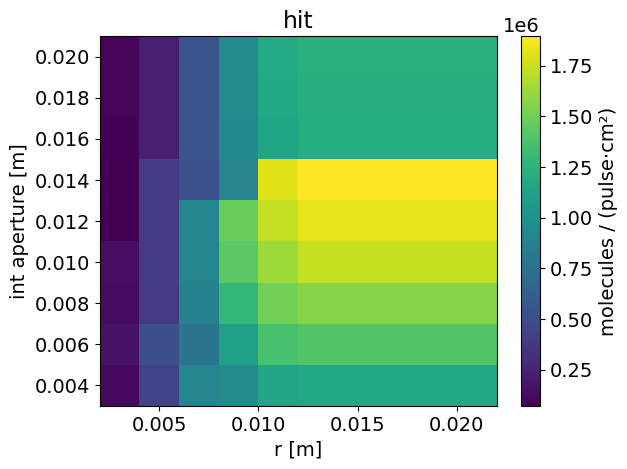

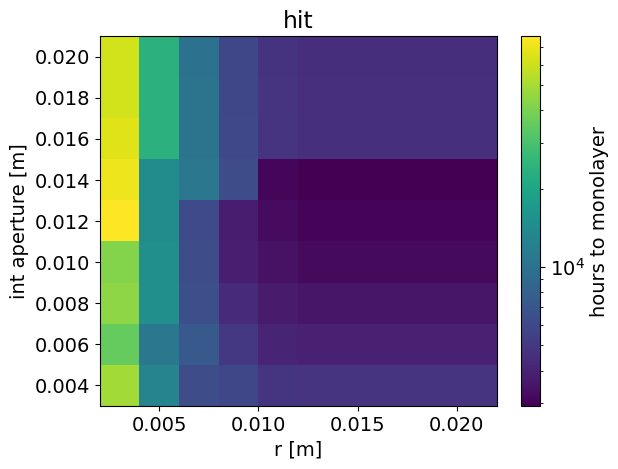

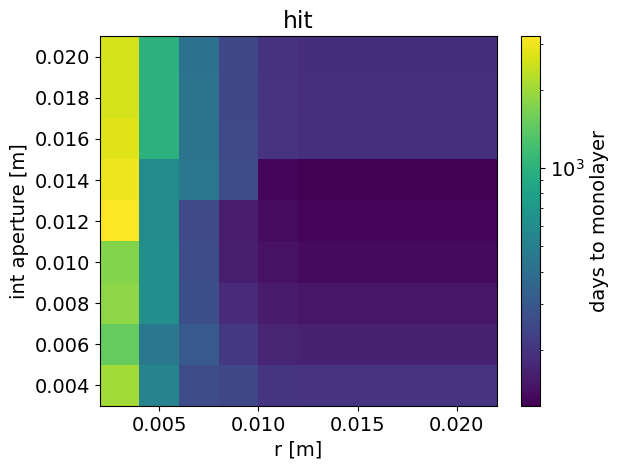

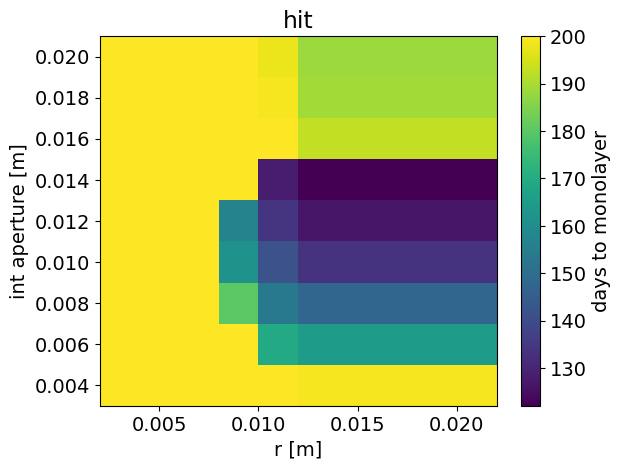

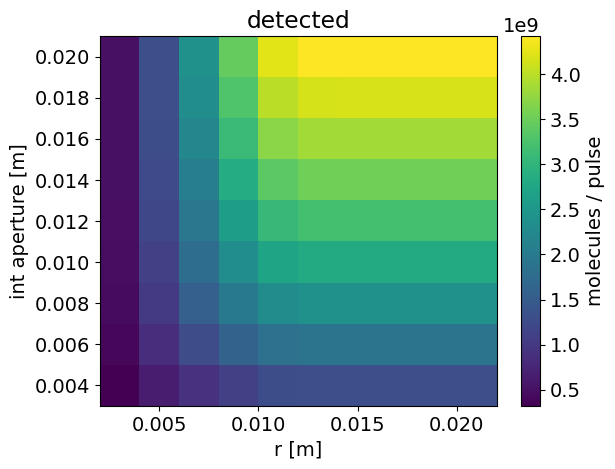

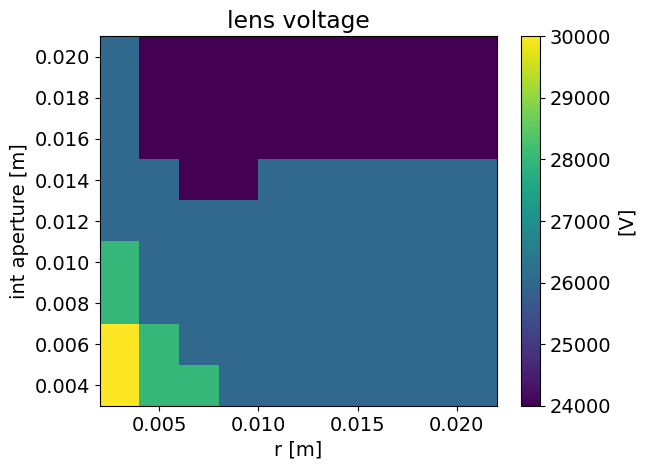

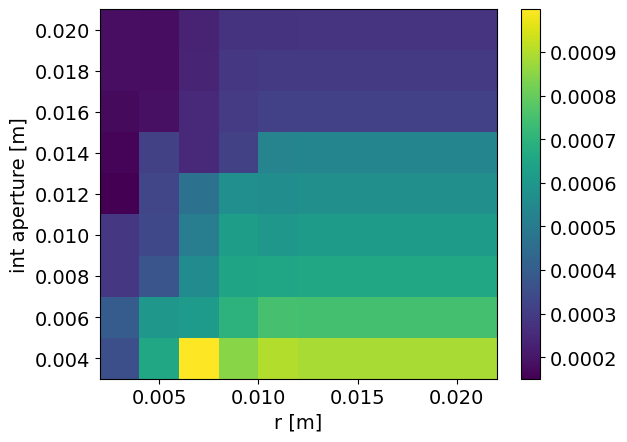

In [40]:
import matplotlib.colors as colors

tmp = dat_opt.copy()
tmp = tmp.reshape((radii.size, interaction_apertures.size, -1))

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 3])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("molecules / (pulse⋅cm²)")
ax.set_title("hit")

z = 1e15 / (tmp[:, :, 3] * 50 * 3600)

fig, ax = plt.subplots()
cax = ax.pcolormesh(
    tmp[:, :, 0],
    tmp[:, :, 1],
    z,
    norm=colors.LogNorm(z[np.isfinite(z)].min(), z[np.isfinite(z)].max()),
)
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("hours to monolayer")
ax.set_title("hit")


z = 1e15 / (tmp[:, :, 3] * 50 * 3600 * 24)

fig, ax = plt.subplots()
cax = ax.pcolormesh(
    tmp[:, :, 0],
    tmp[:, :, 1],
    z,
    norm=colors.LogNorm(z[np.isfinite(z)].min(), z[np.isfinite(z)].max()),
)
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("days to monolayer")
ax.set_title("hit")


z = 1e15 / (tmp[:, :, 3] * 50 * 3600 * 24)

fig, ax = plt.subplots()
cax = ax.pcolormesh(
    tmp[:, :, 0],
    tmp[:, :, 1],
    z,
    vmin=z.min(),
    vmax=200,
)
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("days to monolayer")
ax.set_title("hit")

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 4])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("molecules / pulse")
ax.set_title("detected")

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 2])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("[V]")
ax.set_title("lens voltage")

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 3] / tmp[:, :, 4])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
